# How to Visualize Filters of Convolutional Neural Networks

## In this blogpost we will visualize the filters of resnet-50 architecture

In [1]:
#collapse
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tqdm.notebook import tqdm
from torchsummary import summary
import gc

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# model that need to be visualised
# we will visualise resnet-50 model
model = models.resnet50(pretrained=True)

In [5]:
#hide
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#hide
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

To visualize filters of convnet there are different techniques out there. 
One that we are going to see here is very straight forward. what we do here is we simply plot weights of filters of first convolutional layer of network. We do this because first layer operates directly on images having 3 channels(RGB) so therfore every filters in that layer will have 3 channels too. Thats why we can plot those filters directly as image.

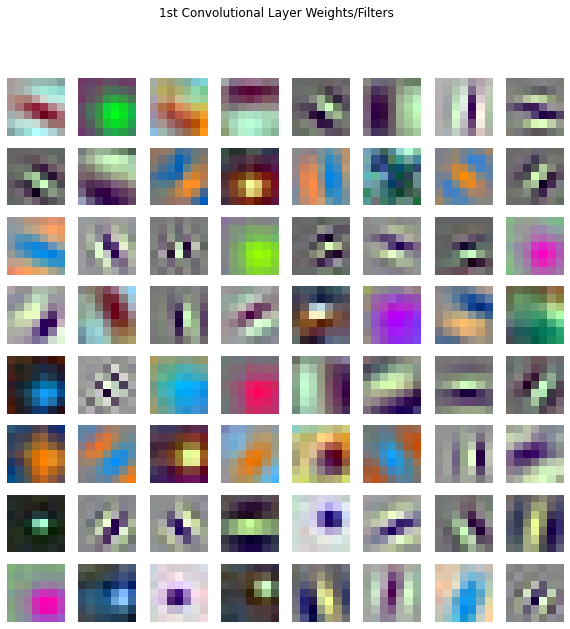

In [ ]:
# here we will visualise the filters of first convolution layers of model
# i.e conv1
plt.figure(figsize=(10, 10))
for i, filter_weight in enumerate(model.conv1.weight):
    plt.subplot(8, 8, i + 1)
    v = filter_weight
    min, max = torch.min(v), torch.max(v)
    v = (v - min) / (max - min)
    plt.imshow(v.permute(1, 2, 0).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.suptitle('1st Convolutional Layer Weights/Filters')

As from the above visualization of filters we can see what does convnets learn in its early layers.  
Filters like above are used to extract very basic low level things like edges with different oreintations and color blobs.  
In fact, if you visualize initial layers of different convnet archictecture you will find somewhat similar figures as shown above.  
This gives us the evidence that convnets learns about images in different level of hierarchy from very low level in early layers to more abstract level in deeper layers.
***

Hooks are just a callback function that are executed during forward/backward pass.
We need hooks because activations are only present in memory till the computation of gradients and after that they are deleted.
So explicitly stores those activations.


In [6]:
class SaveFeatures:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, inp, out):
        self.features = out
        
    def close(self):
        self.hook.remove()

Here we generate an image with random values 

In [7]:
# returns a dummy image 
def get_image(height, width):
    image = np.uint8(np.random.uniform(150, 180, (height, width, 3)))/255
    return image

Visualizing weights directly for layers other than first is not trivial so there is another way to visualize what the particular filter in convnet is looking for.  
This method is based on optimisation of randomly initialised image fed to the convnet. This is similar to classifying image using convnet.  
The only difference here is we update image instead of weights of convnet after each backward pass and target for convnet is chosen by us that is which filters activations we want to be highest.  
Highest activation of a particular filter suggest that convnet is looking at the pattern in the image for which the 
filter was trained for.

In [ ]:
#collapse
class FilterVisualizer():
    def __init__(self, model, module, size=(56, 56),
                 upscaling_steps=12, upscaling_factor=0.95):
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        self.module = module
        self.model = model.eval()

    def visualize(self, filter, lr=0.01, opt_steps=20, blur=None):
        sz = self.size
        sz1 = sz[0]
        sz2 = sz[1]
        
        activations = SaveFeatures(self.module)  # register hook
        
        img = get_image(*sz)
        for _ in range(self.upscaling_steps):  # scale the image up upscaling_steps times
            img_var = torch.tensor(img).to(device)
            img_var = img_var.unsqueeze(0).permute(0, 3, 1, 2).float().requires_grad_()
            

            optimizer = optim.Adam([img_var], lr=lr, weight_decay=1e-6)
            for n in range(opt_steps):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                self.model(img_var)
                loss = -activations.features[0, filter].mean()
                loss.backward()
                optimizer.step()

            img = img_var.data.cpu().numpy()[0].transpose(1,2,0)
            sz1 = int(self.upscaling_factor * sz1)
            sz2 = int(self.upscaling_factor * sz2)  # calculate new image size
            
            img = cv2.resize(img, (sz1, sz2), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur), 0)  # blur image to reduce high frequency patterns
              
        activations.close()
        
        return np.clip(img, 0, 1)

In [ ]:
f1 = FilterVisualizer(model, model.conv1, size=(56, 56),
                      upscaling_steps=20, upscaling_factor=1.11)

  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


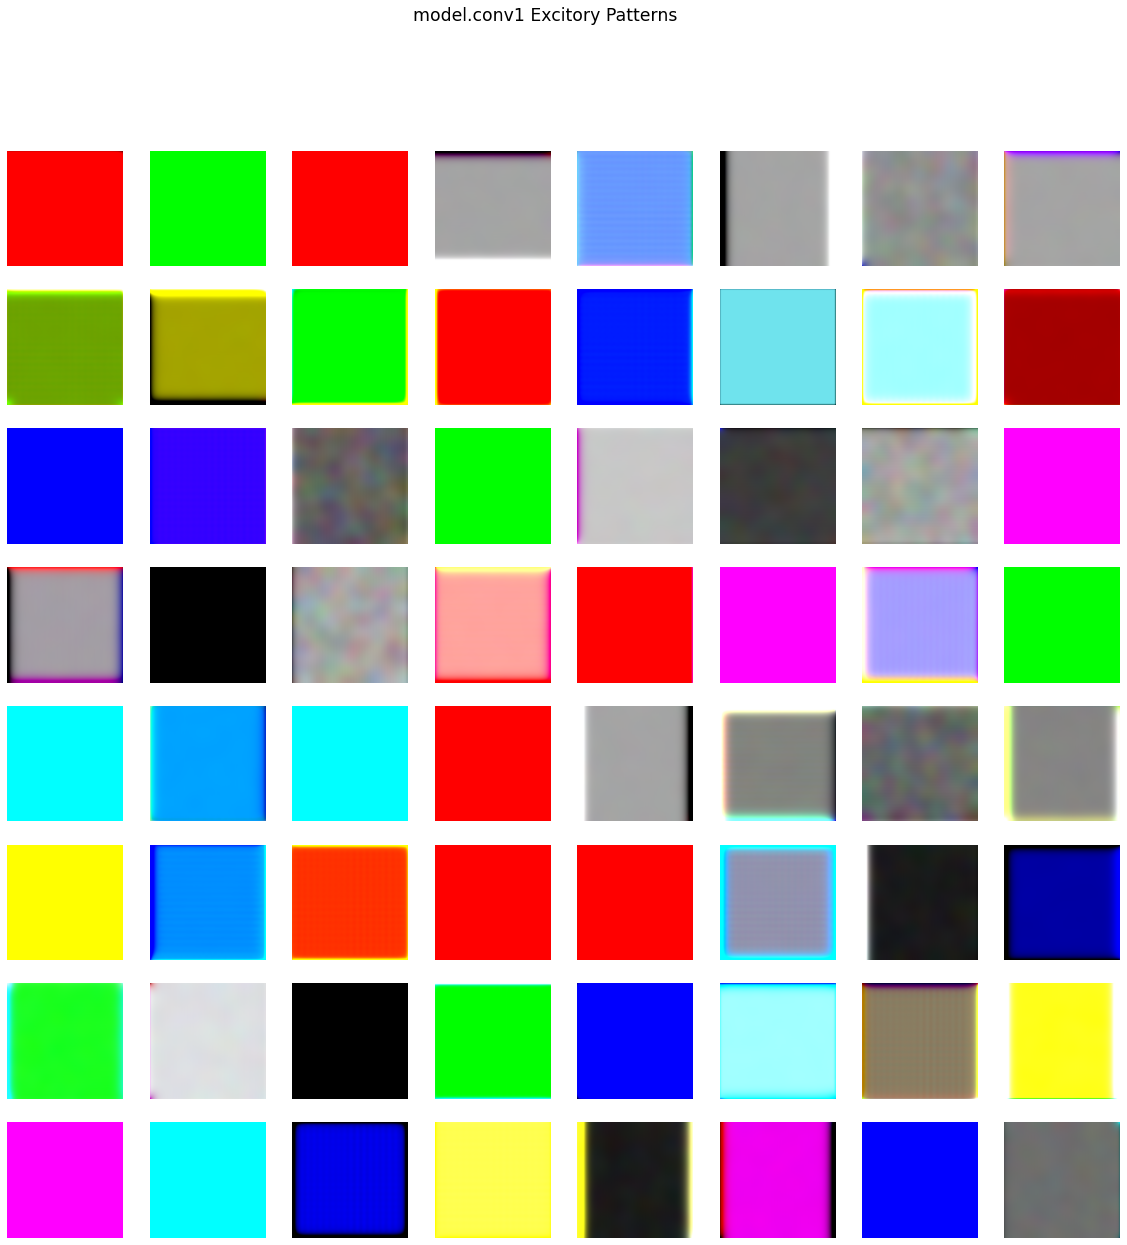

In [ ]:
# here we will visualise the filters of first convolution layers of model
# i.e conv1

plt.figure(figsize=(20, 20))
for i in tqdm(range(64)):
    plt.subplot(8, 8, i + 1)
    v = f1.visualize(i, opt_steps=20, lr=0.01, blur=5)
    min, max = np.min(v), np.max(v)
    v = (v - min) / (max - min)
    plt.imshow(v)
    plt.axis('off')
    plt.suptitle('model.conv1 Excitory Patterns', size='xx-large')

In [ ]:
f2 = FilterVisualizer(model, model.layer1[0].conv1,
                      upscaling_steps=15, upscaling_factor=1.11)

  0%|          | 0/64 [00:00<?, ?it/s]

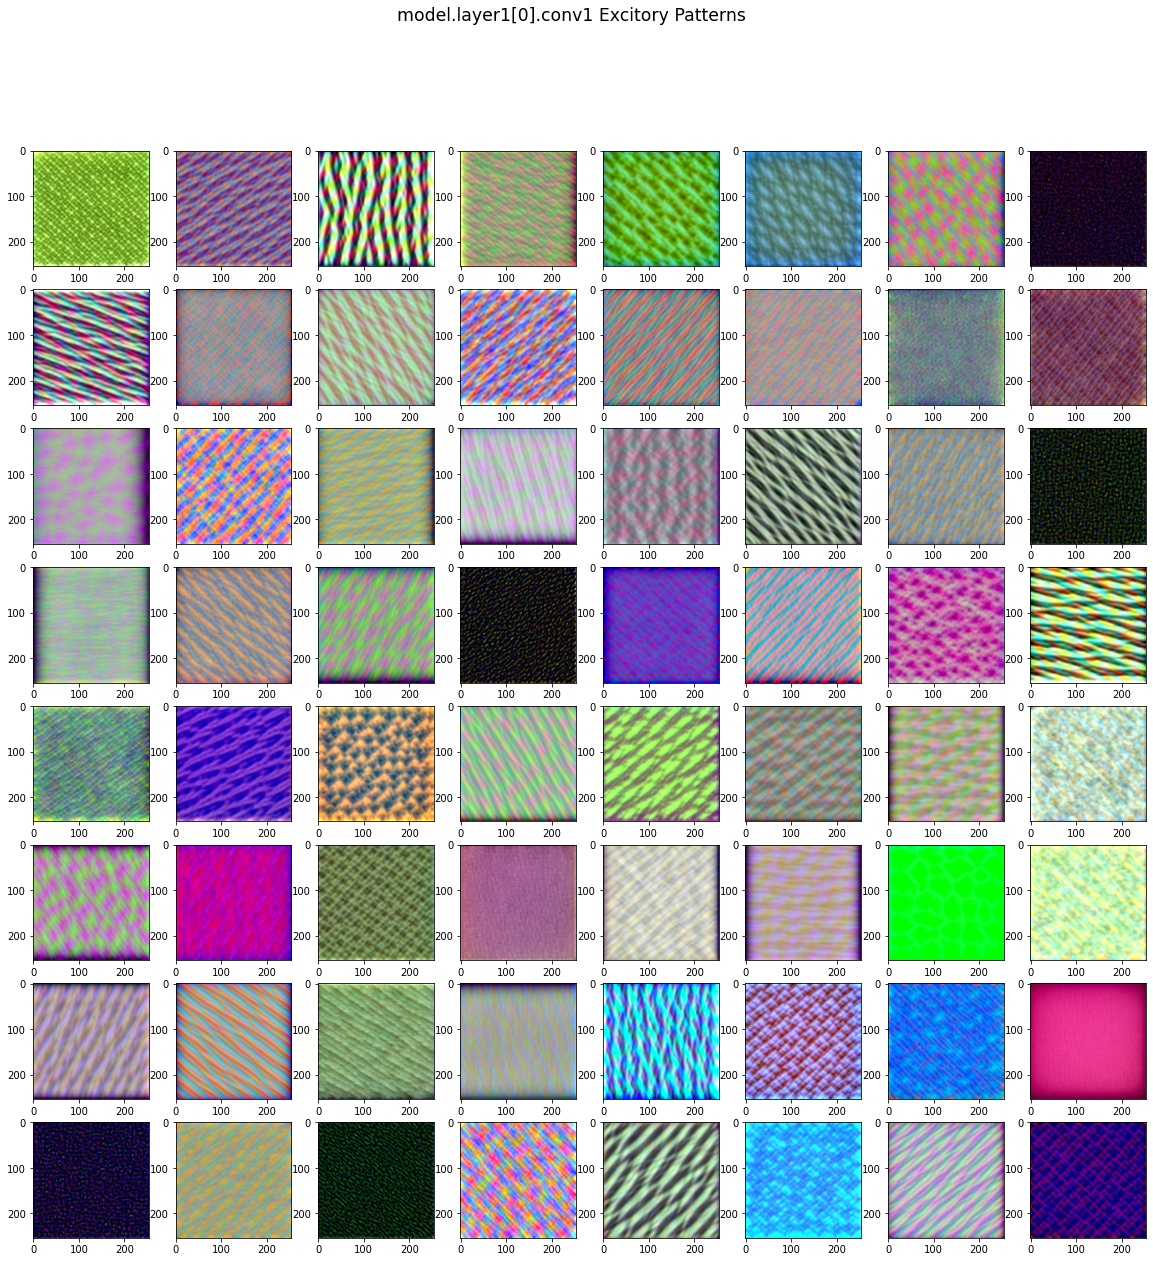

In [ ]:
# here we will visualise the filters of first convolution layers of model
# i.e conv1

plt.figure(figsize=(20, 20))
for i in tqdm(range(64)):
    plt.subplot(8, 8, i + 1)
    v = f2.visualize(i, blur=5)
    min, max = np.min(v), np.max(v)
    v = (v - min) / (max - min)
    plt.imshow(v)
    #plt.axis('off')
    plt.suptitle('model.layer1[0].conv1 Excitory Patterns', size='xx-large')

In [ ]:
f3 = FilterVisualizer(model, model.layer3[0].conv2,
                      upscaling_steps=15, upscaling_factor=1.11)

  0%|          | 0/64 [00:00<?, ?it/s]

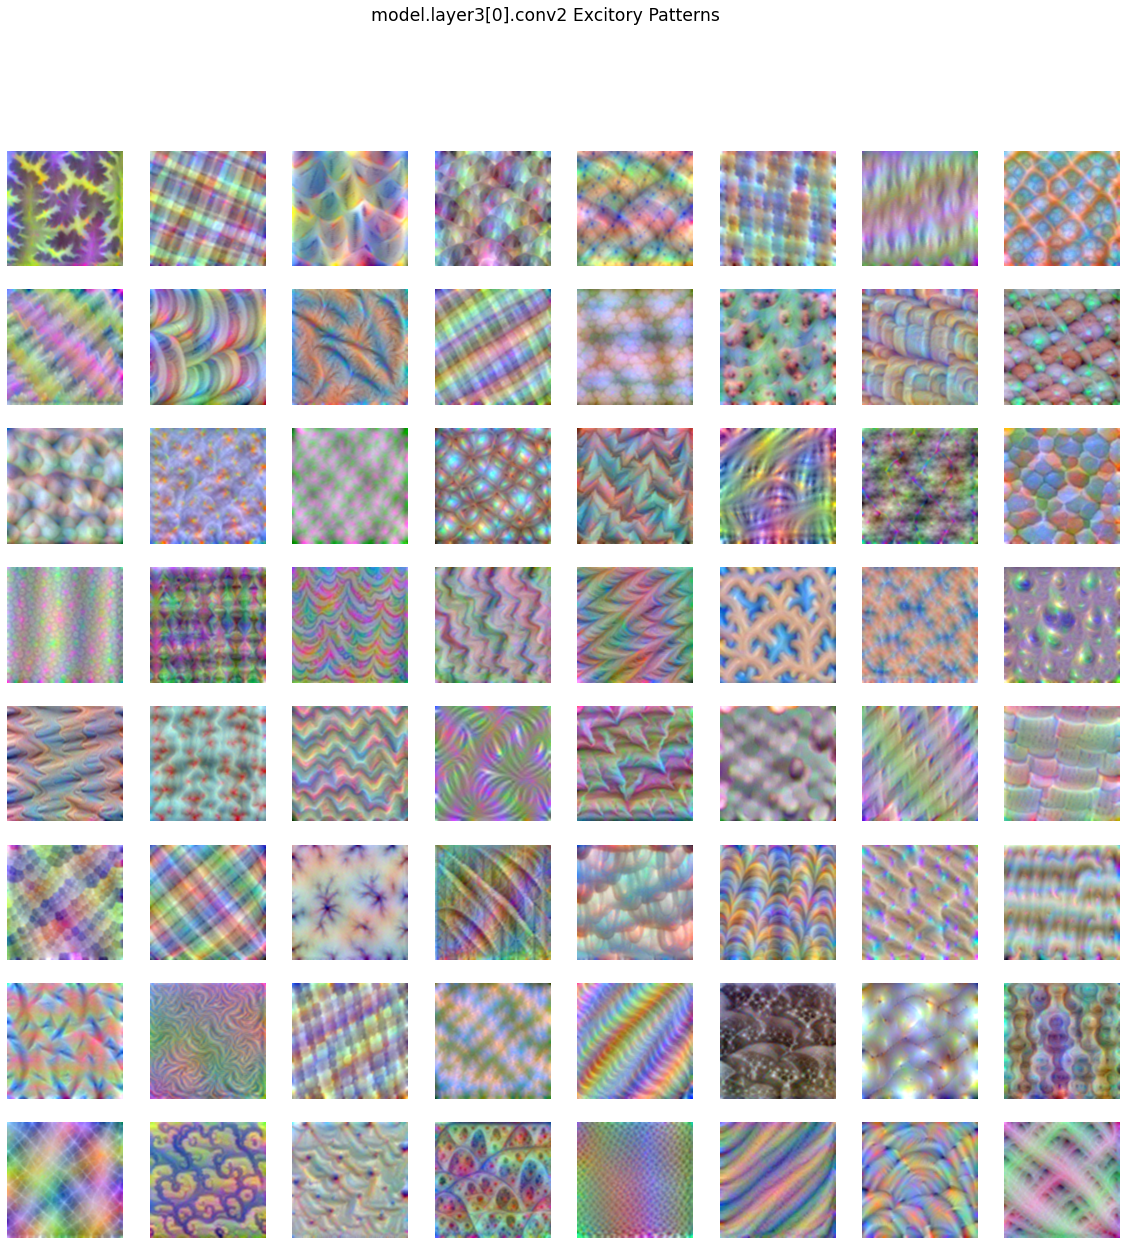

In [ ]:
# here we will visualise the filters of first convolution layers of model
# i.e conv1

plt.figure(figsize=(20, 20))
for i in tqdm(range(64)):
    plt.subplot(8, 8, i + 1)
    v = f3.visualize(i, blur=5)
    min, max = np.min(v), np.max(v)
    v = (v - min) / (max - min)
    plt.imshow(v)
    plt.axis('off')
    plt.suptitle('model.layer3[0].conv2 Excitory Patterns', size='xx-large')

In [ ]:
f4 = FilterVisualizer(model, model.fc,
                      upscaling_steps=25, upscaling_factor=1.11)

In [ ]:
#collapse
# to brighten image
def brighten(np_image, factor=1):
  im = Image.fromarray((np_image*255).astype(np.uint8))
  enhancer = ImageEnhance.Brightness(im)
  return enhancer.enhance(factor)

In [ ]:
#collapse
classes = {0: 'tench, Tinca tinca',
           1: 'goldfish, Carassius auratus',
           2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
           3: 'tiger shark, Galeocerdo cuvieri',
           4: 'hammerhead, hammerhead shark',
           5: 'electric ray, crampfish, numbfish, torpedo',
           6: 'stingray',
           7: 'cock',
           8: 'hen',
           9: 'ostrich, Struthio camelus',
           10: 'brambling, Fringilla montifringilla',
           11: 'goldfinch, Carduelis carduelis',
           12: 'house finch, linnet, Carpodacus mexicanus',
           13: 'junco, snowbird',
           14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
           15: 'robin, American robin, Turdus migratorius'}

  0%|          | 0/16 [00:00<?, ?it/s]

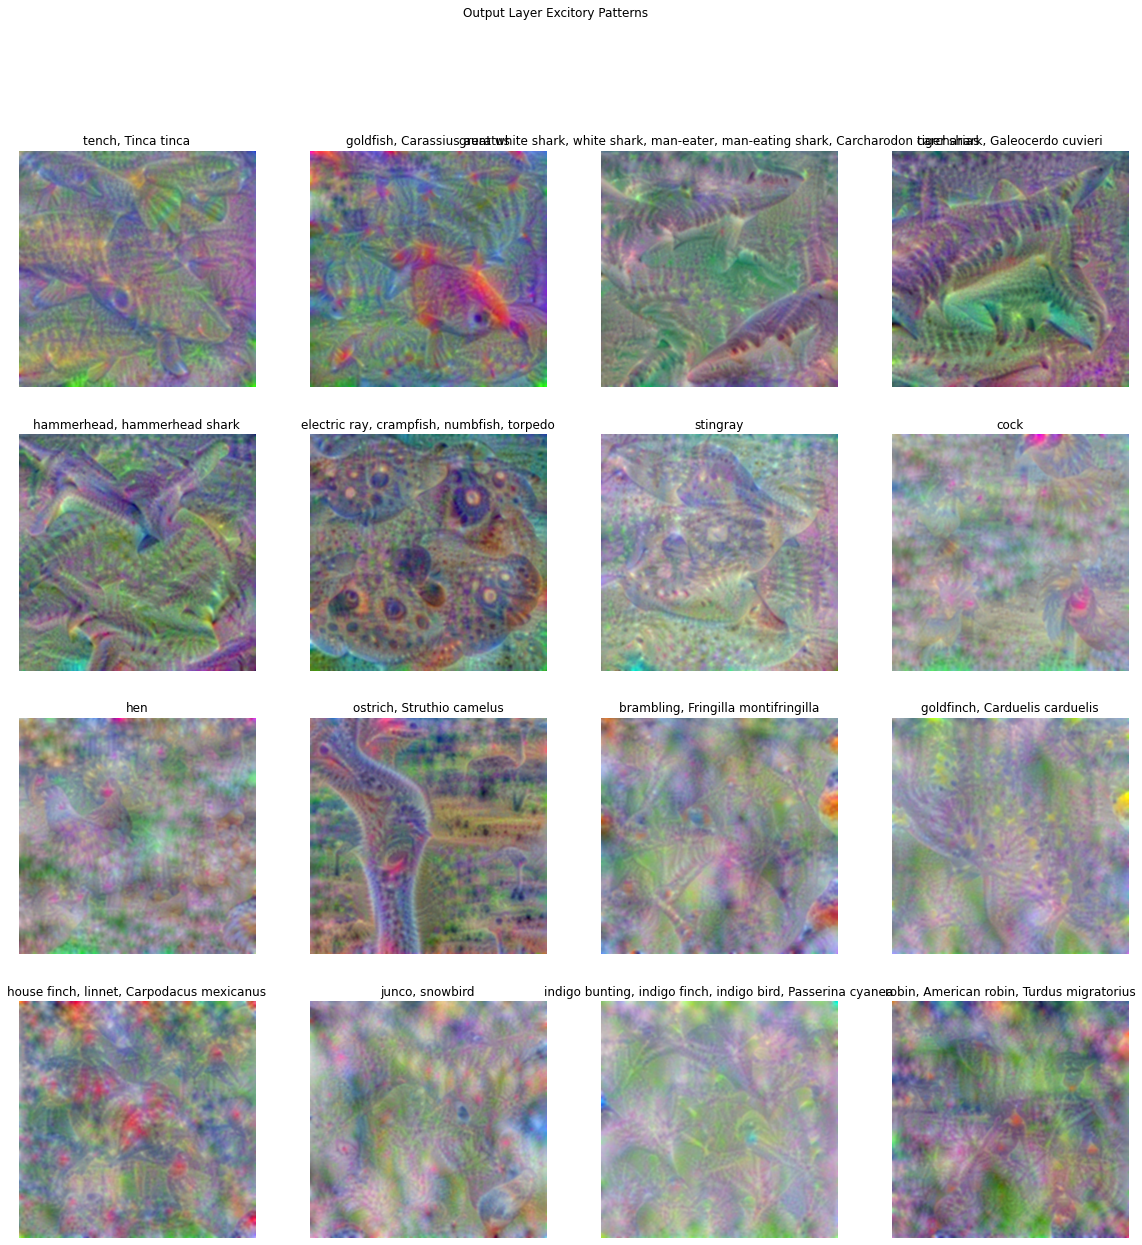

In [ ]:
# here we will visualise the filters of first convolution layers of model
# i.e conv1

plt.figure(figsize=(20, 20))
for i in tqdm(range(16)):
    plt.subplot(4, 4, i + 1)
    v = f4.visualize(i, blur=7)
    min, max = np.min(v), np.max(v)
    v = (v - min) / (max - min)
    plt.imshow(v)
    plt.axis('off')
    plt.title(f'{classes[i]}')
    plt.suptitle('Output Layer Excitory Patterns')

The above visualizations are from last fully-connected layer of resnet50 and these are class specific.  
The visualization is not very clear but we can find some class specific parts in above images.

if you want to read more about visualizations of neural nets you should read this [blog](https://distill.pub/2017/feature-visualization/)

And you can also see more detailed visualizations of some famous architectures at OpenAi's [microscope](https://microscope.openai.com/models)

if you had visited above given links and wish to create visualizations like those than you should use **lucid** library if you are **tensorflow** user or **lucent** if you are **pytorch** user.